# Convolutional Neural Networks for ECG Classification

**IMPORTANT NOTE** Please read the [previous post](MLP.ipynb) before this. They are dependent on one another.

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Understanding Convolutional Neural Networks (CNNs)
 
## CNNs vs MLPs: A Detailed Comparison
 
### Multi-Layer Perceptron (MLP) Review
 
 Think of an MLP like a city's voting system:
 - Each voter (input) connects to every council member (first layer neuron)
 - Each council member connects to every mayor candidate (next layer neuron)
 - Every connection is independent
 
 ```python
 # MLP Example
 model = Sequential([
     Dense(256, input_shape=(187,)),  # Every input connects to every neuron
     Dense(128),                      # Every neuron connects to every neuron in next layer
 ])
 ```
 
 Problems with this approach for signals:
 1. Too many parameters (connections)
 2. Doesn't consider local patterns
 3. Loses spatial/temporal relationships
 4. Position-dependent learning
 
### Convolutional Neural Network (CNN) Approach
 
 Think of a CNN like a medical team reviewing an ECG:
 - Doctors use a sliding window to look at small sections
 - They recognize patterns regardless of where they appear
 - They combine information from multiple scales
 
 ```python
 # CNN Example
 model = Sequential([
     Conv1D(64, kernel_size=3, input_shape=(187, 1)),  # Looks at 3 timepoints at once
     MaxPooling1D(2),                                  # Summarizes every 2 points
 ])
 ```
 
### Key Components of a CNN
 
#### 1. Convolutional Layers
 
 Like a doctor's trained eye:
 - Slides across the signal
 - Looks at small sections (kernel_size)
 - Searches for specific patterns (filters)
 
 Example with numbers:
 ```
 Signal:      [1, 2, 3, 4, 5]
 Kernel:      [1, 0, -1]
 Result:      Detects changes in signal
 ```
 
 Real ECG application:
 - Kernel might detect QRS complex
 - Another kernel finds P waves
 - Different kernels for different patterns
 
#### 2. Pooling Layers
 
 Like summarizing findings:
 - Takes a section of signal
 - Keeps most important information
 - Reduces data size
 
 Example:
 ```
 Signal:      [1, 2, 4, 1]
 MaxPooling:  [2, 4]     # Keeps maximum values
 ```
 
#### 3. Filter/Channel Concept
 
 Like different medical tests:
 - Each filter looks for different patterns
 - Combines results for complete picture
 - Builds complexity through layers
 
 ```
 Layer 1 filters: Basic waves
 Layer 2 filters: Wave combinations
 Layer 3 filters: Complete patterns
 ```
 
### Why CNNs Work Better for ECG
 
#### 1. Parameter Efficiency
 
 MLP approach:
 ```
 187 inputs × 256 neurons = 47,872 parameters (first layer)
 ```
 
 CNN approach:
 ```
 3 (kernel size) × 64 (filters) = 192 parameters (first layer)
 ```
 
#### 2. Translation Invariance
 
 MLP:
 - Must learn pattern at every position
 - Like memorizing QRS complex at every time point
 
 CNN:
 - Learns pattern once
 - Recognizes it anywhere in signal
 - Like knowing what a QRS complex looks like and finding it
 
#### 3. Hierarchical Feature Learning
 
 MLP:
 - Tries to learn everything at once
 - No inherent structure for building complexity
 
 CNN:
 ```
 Layer 1: Simple waves
    ↓
 Layer 2: Wave combinations
    ↓
 Layer 3: Complete heart beat patterns
 ```
 
### Visual Example of Convolution Operation
 
Let's visualize how a convolution works:

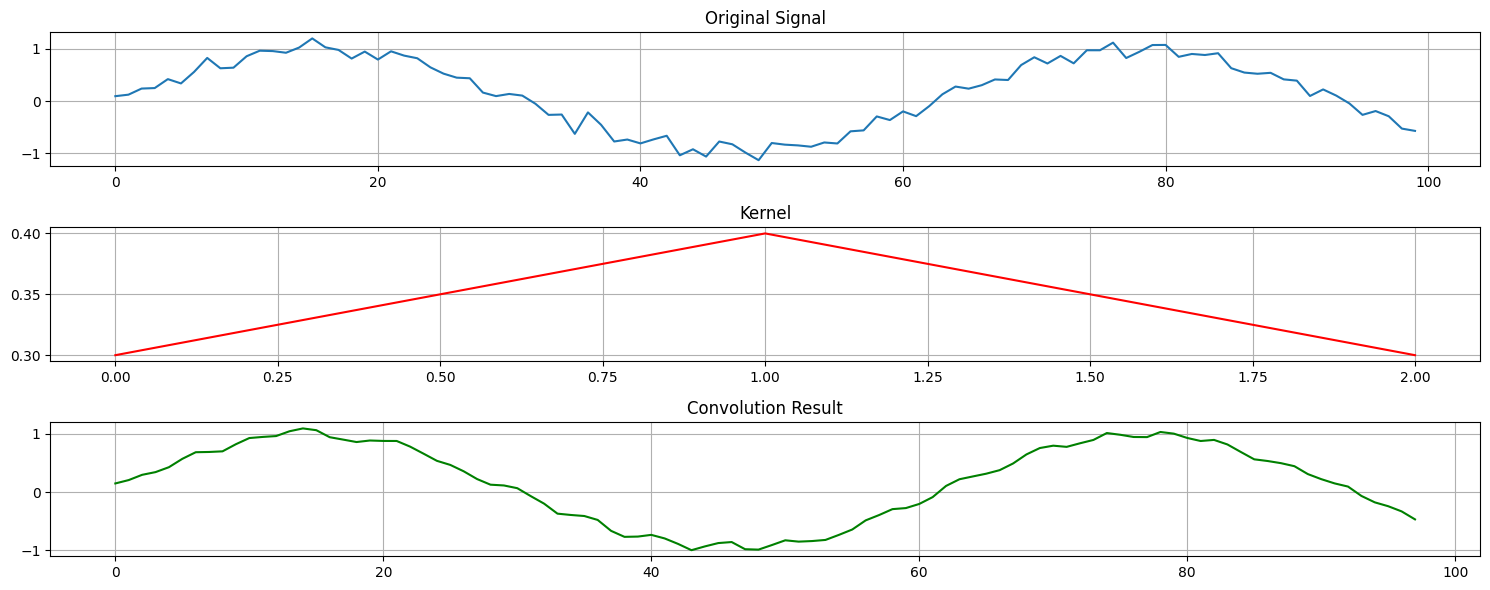

In [14]:
def demonstrate_convolution():
    # Create a simple signal
    t = np.linspace(0, 10, 100)
    signal = np.sin(t) + np.random.normal(0, 0.1, 100)
    
    # Define a simple kernel
    kernel = np.array([0.3, 0.4, 0.3])  # Simple smoothing kernel
    
    # Perform manual convolution for visualization
    conv_result = np.zeros(len(signal) - len(kernel) + 1)
    for i in range(len(conv_result)):
        conv_result[i] = np.sum(signal[i:i+len(kernel)] * kernel)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    
    plt.subplot(3, 1, 1)
    plt.plot(signal)
    plt.title('Original Signal')
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.plot(kernel, 'r')
    plt.title('Kernel')
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.plot(conv_result, 'g')
    plt.title('Convolution Result')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

demonstrate_convolution()

### Architectural Decisions for ECG Data
 
#### 1. Kernel Size Selection
 
 We chose kernel_size=3 because:
 - ECG patterns span multiple time points
 - Small enough to capture fine detail
 - Large enough to see pattern changes
 
#### 2. Number of Filters
 
 Progressive increase (64 → 128 → 256):
 - First layer: Basic wave detection
 - Second layer: Wave combinations
 - Third layer: Complex patterns
 
#### 3. Pooling Strategy
 
 MaxPooling with pool_size=2:
 - Preserves strong features (peaks)
 - Reduces signal length gradually
 - Maintains temporal relationships
 
### Practical Impact
 
 1. **Training Speed**
    - CNN: Fewer parameters = faster training
    - MLP: Many parameters = slower training
 
 2. **Memory Usage**
    - CNN: More efficient parameter sharing
    - MLP: Requires more memory for parameters
 
 3. **Accuracy**
    - CNN: Better at finding signal patterns
    - MLP: May miss subtle temporal patterns
 
 4. **Generalization**
    - CNN: Better at handling signal variations
    - MLP: More sensitive to exact signal position

## Understanding Convolution Operations
 
 In 1D convolution (which we'll use for ECG data):
 1. A kernel (small window) slides across the signal
 2. At each position, it computes a weighted sum
 3. This creates a new signal highlighting specific patterns
 
 Example:
 - Input signal: ECG readings over time
 - Kernel might detect:
   * Sharp peaks (QRS complex)
   * Gradual waves (P and T waves)
   * Baseline variations
 
### Loading and Preparing Data
 
 For CNNs, we need to reshape our data to include a channel dimension:
 [samples, timesteps, channels]

In [15]:
# Load the data
X = pd.read_csv('ECG_dataX.csv')
Y = pd.read_csv('ECG_dataY.csv')

# Convert to numpy arrays
X = X.values
Y = Y.values.reshape(-1)

# Add channel dimension for CNN
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Input shape:", X.shape)
print("Output shape:", Y.shape)

Input shape: (3841, 187, 1)
Output shape: (3841,)


## Visualizing Our Data
 
Like last time, let's look at example signals from each class to understand what patterns the CNN needs to learn.

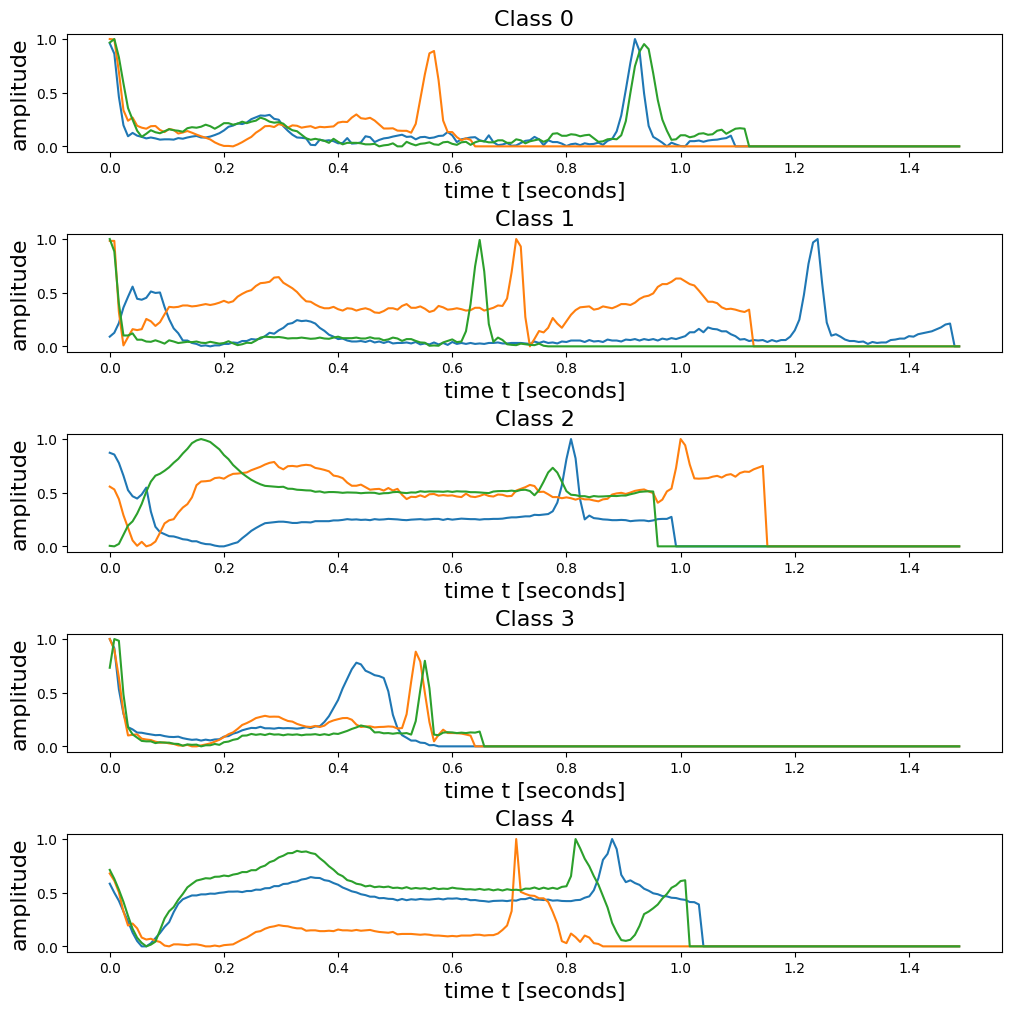

In [16]:
fs = 125  # sampling frequency
Ts = 1/fs  # sampling interval
N = 187    # number of timepoints
Duration = N*Ts  # duration of a signal
t = np.linspace(0, Duration-Ts, N)  # array of timepoints

fig, ax = plt.subplots(5, 1, constrained_layout=True, figsize=(10, 10))
for c in range(5):   
    for n in range(3):
        idx = np.random.randint(0, 10)
        ax[c].plot(t, X[Y==c][idx].reshape(-1))        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title(f'Class {c}', fontsize=16)

## Building the CNN Architecture
 
Our CNN will have multiple convolutional layers:
 1. Each layer learns progressively more complex patterns
 2. Pooling layers reduce dimensionality
 3. Final dense layers combine all information
 
Layer purposes:
 - Conv1D: Pattern detection
 - MaxPooling1D: Feature selection and dimension reduction
 - Dense: Final classification based on extracted features

In [17]:
# Create Model
model = Sequential([
    # Input layer
    tensorflow.keras.Input(shape=(187, 1)), # 187 timepoints, 1 channel
    
    # First Convolutional Block
    Conv1D(filters=64, kernel_size=3, activation='relu'), 
    MaxPooling1D(pool_size=2),  
    
    # Second Convolutional Block
    Conv1D(filters=128, kernel_size=3, activation='relu'),  
    MaxPooling1D(pool_size=2),  
    
    # Third Convolutional Block
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # Flatten and Dense Layers
    Flatten(),  # Flatten the 3D output to 1D tensor
    Dense(128, activation='relu'),  
    Dropout(0.5),   # Dropout for regularization
    Dense(5, activation='softmax')  # 5 classes, so 5 output nodes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 185, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 43, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5376)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       688,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,421 (3.10 MB)

 Trainable params: 812,421 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

 ## Understanding Each Layer

Let's break down what each layer does:

1. **First Conv1D (64 filters)**:
  - Detects basic signal patterns
  - Like finding peaks, valleys, slopes
2. **First MaxPooling**:
  - Reduces signal length by half
  - Keeps strongest features

3. **Second Conv1D (128 filters)**:
    - Combines basic patterns into larger ones
    - Might detect complete wave shapes
 
4. **Final Dense Layers**:
    - Combines all features for classification
    - Makes final decision about ECG class

In [18]:
# Splitting data into train/validation/test sets

# First split: 80% train+val, 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Second split: 90% train, 10% validation from the training set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2764, 187, 1)
Validation set shape: (308, 187, 1)
Test set shape: (769, 187, 1)


## Training the Model
 
During training, we'll:
 1. Monitor both training and validation accuracy
 2. Save the best model
 3. Plot learning curves to understand training dynamics

In [19]:
history = model.fit(X_train, Y_train,
                   batch_size=64,   # number of samples per gradient update
                   epochs=50,    # number of iterations over the entire dataset 
                   validation_data=(X_val, Y_val))

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4169 - loss: 1.3846 - val_accuracy: 0.6169 - val_loss: 1.0163
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6415 - loss: 0.9800 - val_accuracy: 0.6981 - val_loss: 0.8639
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7046 - loss: 0.8122 - val_accuracy: 0.7110 - val_loss: 0.7746
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7336 - loss: 0.7577 - val_accuracy: 0.7403 - val_loss: 0.7133
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7626 - loss: 0.6659 - val_accuracy: 0.7403 - val_loss: 0.6614
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7838 - loss: 0.6139 - val_accuracy: 0.7597 - val_loss: 0.6717
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8000 - loss: 0.5693 - val_accuracy: 0.7727 - val_loss: 0.6298
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8129 - loss: 0.5319 - val_accuracy: 0.7857 - v

## Analyzing Training Results
 
Let's visualize how our model learned over time:
 1. Loss curves show if we're learning effectively
 2. Accuracy curves show performance improvement
 3. Validation metrics show generalization ability

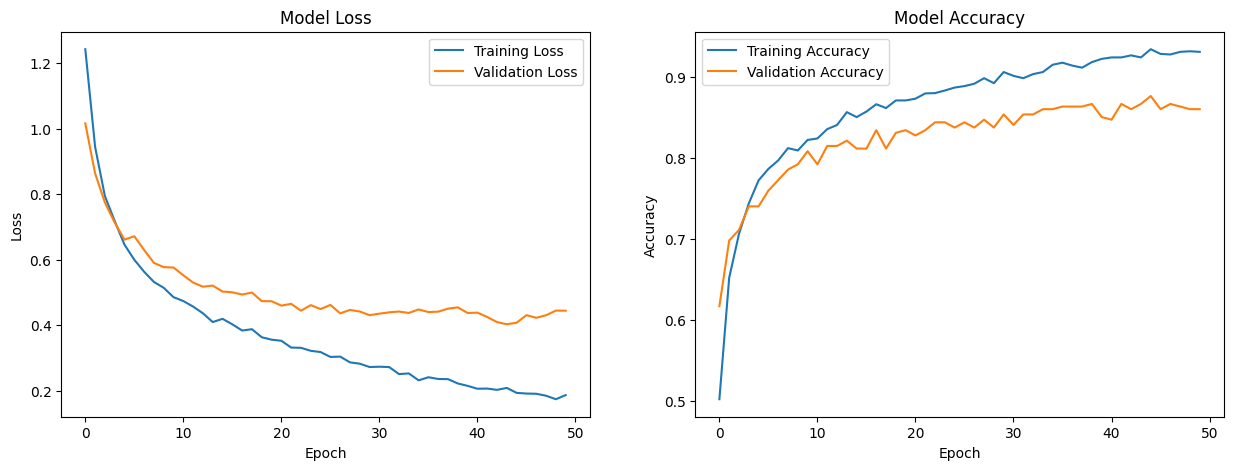

In [20]:
# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy plot
ax[1].plot(history.history['accuracy'], label='Training Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

## Visualizing What Our CNN Has Learned using Salience Map
 
Saliency maps are similar to feature importance graphs. A saliency map visually highlights the most important regions in an image that a machine learning model is focusing on when making a prediction, essentially showing which parts of the input data are most influential in the model's decision-making process, allowing users to understand how the model "looks" at an image and interpret its reasoning behind a prediction. I will explain how to read one in a moment.

In [ ]:
def compute_saliency_map(model, signal, class_idx):
    """
    Compute saliency map showing which parts of the signal are most important
    for classification, with improved gradient handling.
    """
    signal_tensor = tensorflow.convert_to_tensor(signal.reshape(1, -1, 1), dtype=tensorflow.float32)
    
    with tensorflow.GradientTape() as tape:
        tape.watch(signal_tensor)
        predictions = model(signal_tensor)
        # Use softmax to get proper probability distribution
        predictions = tensorflow.nn.softmax(predictions)
        class_score = predictions[:, class_idx]
    
    # Compute gradients and take absolute value
    gradients = tape.gradient(class_score, signal_tensor)
    saliency = np.abs(gradients.numpy()[0, :, 0])
    
    # Normalize saliency map for better visualization
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-8)
    
    return saliency

### Interpreting Saliency Maps
 
The red overlay shows which parts of the signal most influence the classification:
 - Brighter regions are more important for classification
 - Different classes focus on different signal features
 - Helps understand what the model considers diagnostic
 - Can validate if model is learning medically relevant features

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


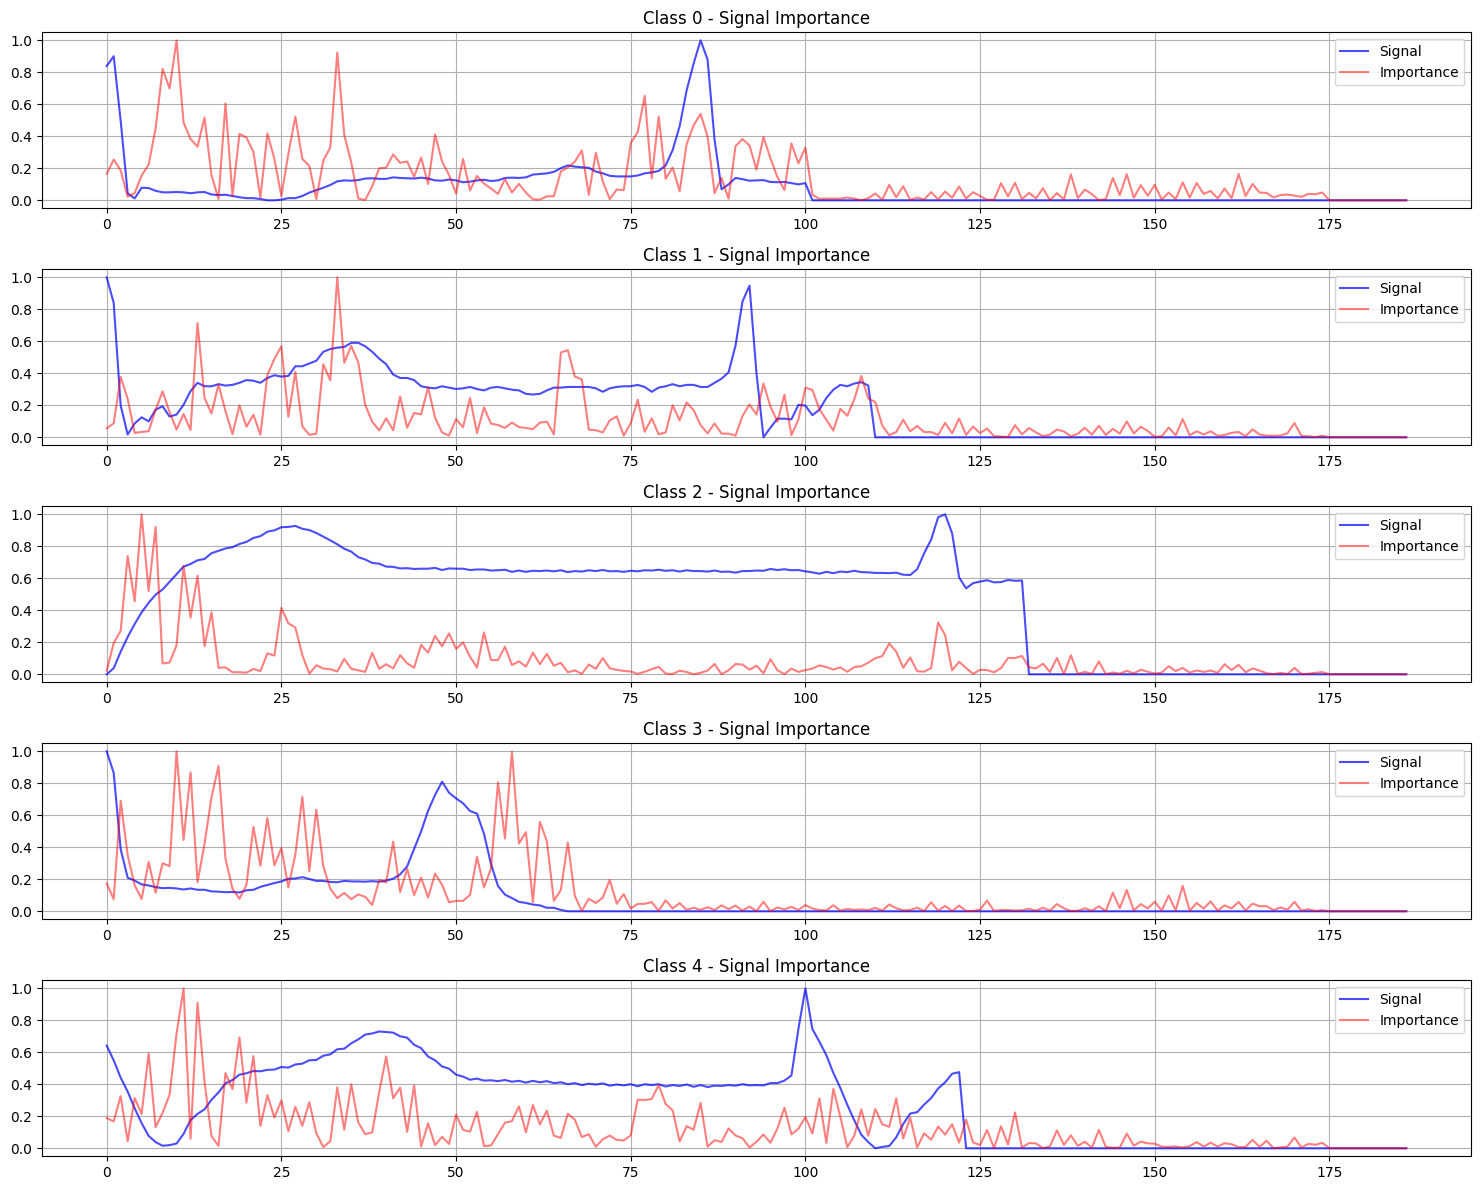

In [ ]:


# Visualize saliency maps with improved computation
plt.figure(figsize=(15, 12))

for class_idx in range(5):
    # Get a correctly classified sample for this class
    correct_samples = np.where((Y_test == class_idx) & (Y_test == np.argmax(model.predict(X_test), axis=1)))[0]
    if len(correct_samples) > 0:
        sample_idx = correct_samples[0]
        sample_signal = X_test[sample_idx]
        saliency = compute_saliency_map(model, sample_signal, class_idx)
        
        plt.subplot(5, 1, class_idx + 1)
        plt.plot(sample_signal.reshape(-1), 'b', label='Signal', alpha=0.7)
        plt.plot(saliency * np.max(np.abs(sample_signal)), 'r', 
                alpha=0.5, label='Importance')
        plt.title(f'Class {class_idx} - Signal Importance')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluating Model Performance
 
Let's check how well our model performs on the test set:
 1. Overall accuracy
 2. Per-class performance
 3. Confusion matrix to understand error patterns

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

# Get predictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_classes))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9074 - loss: 0.2726

Test accuracy: 0.9064
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       176
           1       0.83      0.91      0.87       154
           2       0.94      0.90      0.92       146
           3       0.92      0.93      0.92       122
           4       0.96      0.96      0.96       171

    accuracy                           0.91       769
   macro avg       0.91      0.91      0.91       769
weighted avg       0.91      0.91      0.91       769



## Understanding Confusion Matrices
 
 A confusion matrix shows how well a classification model performs by comparing predicted classes against actual classes.
 
### Reading a Confusion Matrix
 
 For our 5-class ECG problem:
 ```
 Rows: Actual class (ground truth)
 Columns: Predicted class (model output)
 Values: Number of cases
 ```
 
 Example interpretation:
 ```
 Matrix[2,1] = 10 means:
 - 10 cases where actual class was 2
 - Model predicted class 1
 - These are errors!
 ```
 
### Key Metrics from Confusion Matrix
 
 1. **Diagonal elements**: Correct predictions
    - Higher numbers = Better performance
    - Perfect model: Only diagonal has values
 
 2. **Off-diagonal elements**: Mistakes
    - Shows what kinds of errors occur
    - Helps identify model weaknesses
 
 3. **Per-class metrics**:
    - Precision: How many predicted Class X are actually Class X
    - Recall: How many actual Class X were correctly identified
    - Important for understanding class-specific performance
 
 Real-world significance:
 - Medical diagnosis: Missing a condition vs false alarms
 - ECG classification: Critical to know what types of heart conditions might be misclassified

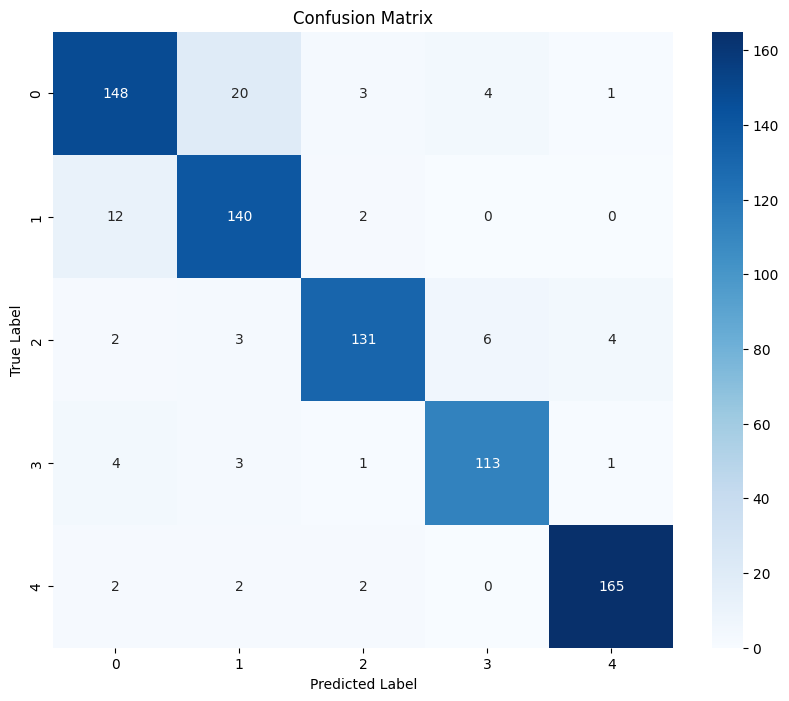

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, Y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Visualizing Model Predictions
 
Let's look at some examples of:
 1. Correct predictions
 2. Incorrect predictions
This helps understand what patterns the model has learned.

Correct Predictions:


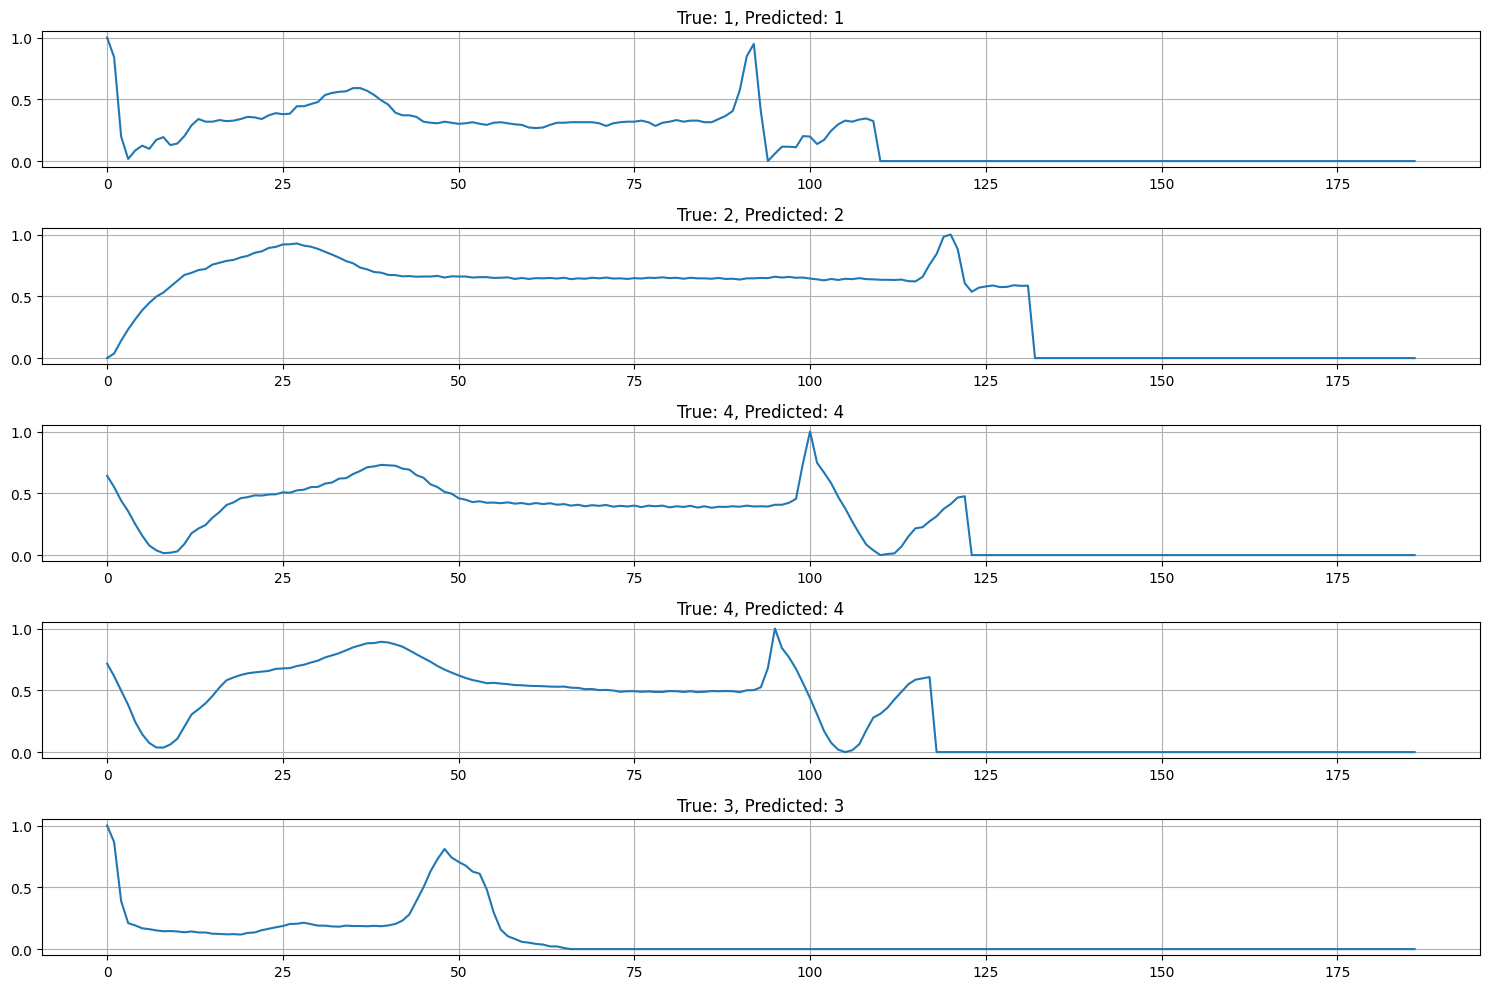

Incorrect Predictions:


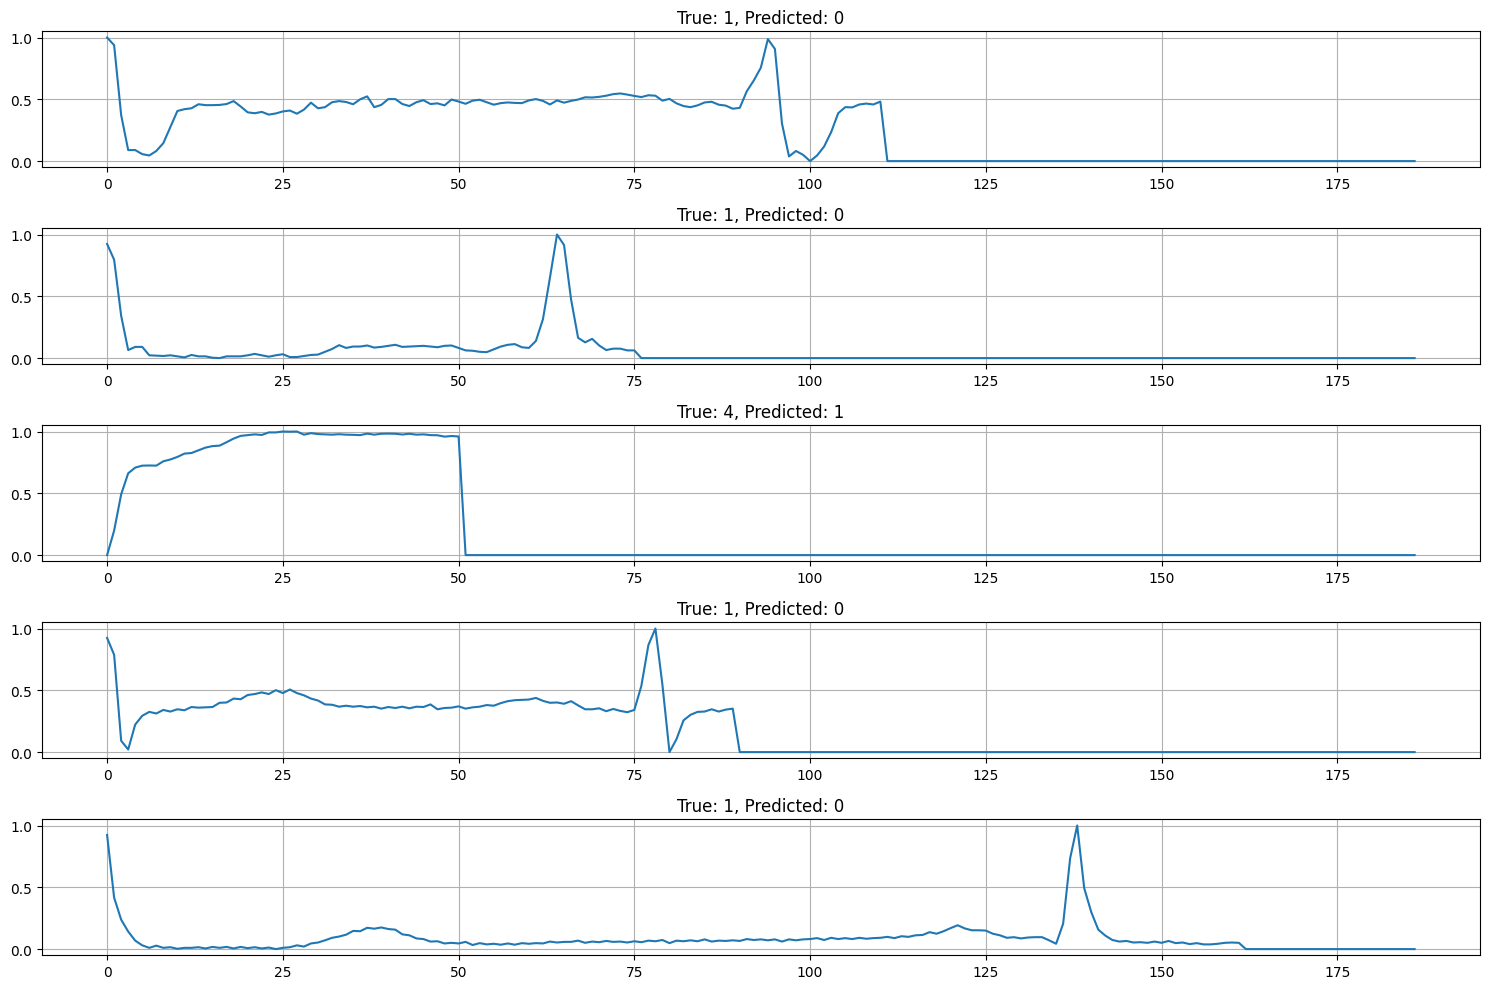

In [ ]:
def plot_predictions(X, y_true, y_pred, num_examples=5):
    """Plot some examples with their predictions."""
    plt.figure(figsize=(15, 10))
    for i in range(num_examples):
        plt.subplot(num_examples, 1, i+1)
        plt.plot(X[i].reshape(-1))
        plt.title(f'True: {y_true[i]}, Predicted: {y_pred[i]}')
        plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot some correct predictions
correct = Y_test == Y_pred_classes
correct_indices = np.where(correct)[0][:5]
print("Correct Predictions:")
plot_predictions(X_test[correct_indices], 
                Y_test[correct_indices],
                Y_pred_classes[correct_indices])

# Plot some incorrect predictions
incorrect = Y_test != Y_pred_classes
incorrect_indices = np.where(incorrect)[0][:5]
print("Incorrect Predictions:")
plot_predictions(X_test[incorrect_indices],
                Y_test[incorrect_indices],
                Y_pred_classes[incorrect_indices])

## Advantages of CNN vs MLP for ECG Classification
 
 1. **Pattern Recognition**:
    - CNN automatically learns relevant features
    - MLP needs to learn from raw signal values
 
 2. **Parameter Efficiency**:
    - CNN shares weights across signal
    - MLP needs separate weights for each input
 
 3. **Temporal Awareness**:
    - CNN preserves temporal relationships
    - MLP treats each timepoint independently
 
 4. **Scale Invariance**:
    - CNN can detect patterns regardless of position
    - MLP needs to learn patterns at each position